# Tutorial for supervised and unsupervised learning with neuroimaging data

(This tutorial is based on nilearn and sklearn examples) 

Sections: 
    1. Load neuroimaging data and define functional connectivity features
        * Downloading the ABIDE dataset
        * Visualize the atlas / ROIs
        * Visualize connectome
      
        
    2. Do some Machine-Learning! 
        * Train and test classifier 
        * Cross-validation and performance evaluation 
        * Subtyping using unsupervised learning
        
Requires: nilearn, sklearn, pandas, seaborn (and other dependencies such as numpy, matplotlib etc) 


**Anaconda package install steps:**

    1. Create env
 
        conda create --name <env_name_here> python=2 

    2. Custom pkgs 
 
        conda install -c=conda-forge nilearn 
        conda install pandas seaborn jupyter
        
** Random Forest example from the slides**
http://www.r2d3.us/visual-intro-to-machine-learning-part-1/


In [1]:
# Python scientific packages
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import os 

# This line allows plotting directly in the notebook
%matplotlib inline

# Where am I
!pwd

/bg01/homescinet/m/mchakrav/nikhil/ss2017_NIML


In [2]:
# useful custom defs
def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    plt.figure(figsize=(n_matrices * 4, 2))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        plt.imshow(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                   interpolation='nearest')        
        plt.title('{0}, subject {1}'.format(matrix_kind, n_subject))
        plt.colorbar()

# Section 1

In [3]:
# Nilearn packages
from nilearn import datasets
from nilearn.datasets import fetch_abide_pcp
from nilearn import decomposition
from nilearn import plotting, image
from nilearn.input_data import NiftiMapsMasker
from nilearn.regions import RegionExtractor
from nilearn.connectome import sym_to_vec
from nilearn.connectome import ConnectivityMeasure

import nibabel as nib

/home/m/mchakrav/nikhil/.conda/envs/SciNet_Workshop_NIML/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/m/mchakrav/nikhil/.conda/envs/SciNet_Workshop_NIML/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading the data

Nilearn provides a bunch of automatic downloaders to ease reproducibility of the analysis. With nilearn, an analysis is run in a single script and can be shared easily.
The nilearn fetchers can be found in the module nilearn.datasets.

In [4]:
## use these commands if you are running this on scinet
my_home = os.environ.get('HOME')
my_scratch = my_home.replace('/home/', '/scratch/')

tutorial_data = os.path.join(my_scratch, 'ss2017_NIML/data/') 

cc200_nii = tutorial_data + 'atlases/cc200_roi_atlas.nii.gz'
aal_nii = tutorial_data + 'atlases/aal_SPM12/aal/atlas/AAL.nii'

## Change these paths if you are running this tutorial on your own laptop

# Feature Selection (Based on priors --> Atlas)

Dimensions of cc200 atlas: (63, 75, 61), Number of ROIs: 201
Dimensions of aal atlas: (91, 109, 91), Number of ROIs: 117


/home/m/mchakrav/nikhil/.conda/envs/SciNet_Workshop_NIML/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/m/mchakrav/nikhil/.conda/envs/SciNet_Workshop_NIML/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


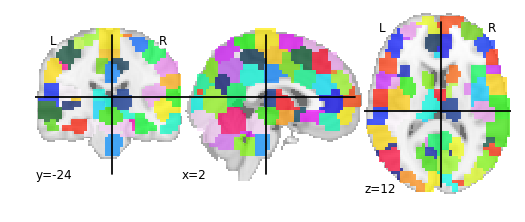

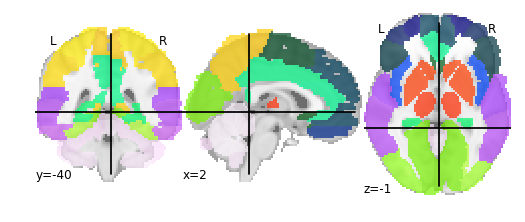

In [5]:
# We define of input feature based on spatial Region of Interests (ROIs) 
# This is prior based dimensionality reduction (ROIs << # of Voxels)

#option 1: cc200 atlas
cc200_atlas_img = nib.load(cc200_nii)

#option 2: AAL
aal_atlas_img = nib.load(aal_nii)
                        
print('Dimensions of cc200 atlas: {}, Number of ROIs: {}'.format(cc200_atlas_img.shape, len(np.unique(cc200_atlas_img.get_data()))))
print('Dimensions of aal atlas: {}, Number of ROIs: {}'.format(aal_atlas_img.shape, len(np.unique(aal_atlas_img.get_data()))))
plotting.plot_roi(cc200_nii)
plotting.plot_roi(aal_atlas_img)


# Preprocessed Sample

For the rest of the tutorial, we will work on 172 subjects from the NYU acquisition site. Fortunately, the Preprocessed Connectome Project provides directly the time series extracted from several atlases.

In [6]:
# Download preprocessed data at a given location (Doesn't overwrite)
abide = fetch_abide_pcp(data_dir=tutorial_data, derivatives=['rois_cc200','rois_dosenbach160','func_preproc'],
                        SITE_ID=['NYU'], pipeline='cpac')

print('Saving fetched data at: {}'.format(tutorial_data))

Saving fetched data at: /scratch/m/mchakrav/nikhil/ss2017_NIML/data/


In [7]:
# Data sizes: 1. single subject image data, 2. Flattened ROI data for all subjects
print('Path to single subject func img data: {}'.format(abide.func_preproc[0]))
# Single subject data
func = abide.func_preproc[0]
func_nib = nib.load(func)
func_data = func_nib.get_data()
print('Single subject data shape: {}').format(func_data.shape)
print('')

#Atlas for estimating connectome
connectome_data = abide.rois_dosenbach160
print('Flattened rois_dosenbach160 dataset (time,subs,roi): {}'.format(np.array(connectome_data).shape))

Path to single subject func img data: /scratch/m/mchakrav/nikhil/ss2017_NIML/data/ABIDE_pcp/cpac/nofilt_noglobal/NYU_0050952_func_preproc.nii.gz
Single subject data shape: (61, 73, 61, 176)

Flattened rois_dosenbach160 dataset (time,subs,roi): (172, 176, 161)


# Connectomes Estimation

Connectivity is typically estimated using correlation between time series. Recent studies has shown that partial correlation could give better results. Different estimators can also be used to apply some regularization on the matrix coefficients. Nilearn's ConnectivityMeasure object (in the nilearn.connectome module) provides three types of connectivity matrix: correlation, partial_correlation, and tangent (a method developped in our laboratory). ConnectivityMeasure can also use any covariance estimator shipped by scikit-learn (ShrunkCovariance, GraphLasso).
In a first time, we estimate the connectivity using default parameters. We check that we have one matrix per subject.

In [8]:
conn_est = ConnectivityMeasure(kind='correlation') #'partial correlation'
conn_matrices = conn_est.fit_transform(connectome_data)
conn_matrices.shape

(172, 161, 161)

* **Plotting connectivity matrix**

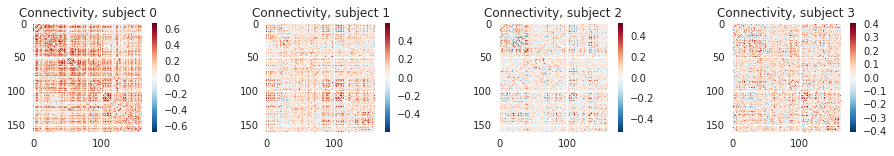

In [9]:
number_of_subs = 4
plot_matrices(conn_matrices[:number_of_subs,:,:], 'Connectivity')

/home/m/mchakrav/nikhil/.conda/envs/SciNet_Workshop_NIML/lib/python2.7/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))
/home/m/mchakrav/nikhil/.conda/envs/SciNet_Workshop_NIML/lib/python2.7/site-packages/nilearn/plotting/glass_brain.py:164: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  black_bg = colors.colorConverter.to_rgba(ax.get_axis_bgcolor()) \
/home/m/mchakrav/nikhil/.conda/envs/SciNet_Workshop_NIML/lib/python2.7/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


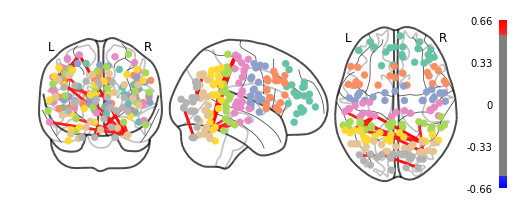

In [10]:
# Visualize the connectome using atlas 
subject_id = 100
dosenbach = datasets.fetch_coords_dosenbach_2010()
coords = np.vstack((dosenbach.rois['x'], dosenbach.rois['y'], dosenbach.rois['z'])).T
plotting.plot_connectome(conn_matrices[subject_id,1:,1:], node_coords = coords, edge_threshold='99.9%',colorbar=True)


# Section 2: Machine Learning

In [11]:
# Useful ML packages
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
import scipy.cluster.hierarchy as sch

# For the following ML example we will use the connectivity features based on the Dosenbach atlas. 

* Extracting useful coefficients from connectivity matrix (flattened array of features)

Connecitivity matrices are symmetric. As such, half of the coefficients are redundant. They can even impact the results of some predictors. In order to "extract" these coefficients, we want to use a mask. numpy.tril function can help us with this task. However, using masking is hazardous without a good knowledge of numpy. Fortunately, nilearn provides a function to do this automatically and efficiently: nilearn.connectome.sym_to_vec.

In [12]:
#Get lower trianle 
X = sym_to_vec(conn_matrices)
X.shape

(172, 13041)

# Setup Cross-Validation paradigm stratified by side_id and diagnosis 

Getting reliable prediction results require to predict on unseen data. Cross-validation consists in leaving out a part of the dataset (testing set) to validate the model learnt on the remaining of the dataset (training set). Scikit-learn has all the utils necessary to do automatic cross-validation. In the case of ABIDE, we have a very heterogenous dataset and we want the sets to be balanced in term of acquisition sites and condition. We use a stratified cross-validation method for that.

In [13]:
# Stratified train and test sets 
ids = []
for site_id, dx in abide.phenotypic[['SITE_ID', 'DX_GROUP']]:
    ids.append(str(site_id) + str(dx))

n_folds = 5
# Shuffle split    
# cv = StratifiedShuffleSplit(ids, n_iter=n_folds, test_size=.2)
# K-fold
cv = StratifiedKFold(ids, n_folds=n_folds)

# DX_GROUP are the labels of the ABIDE dataset. 1=ASD, 2=Healthy
y = abide.phenotypic['DX_GROUP'] - 1

print('class distribution, ASD: {}, Healthy: {}'.format(np.sum(y==0),np.sum(y==1)))

class distribution, ASD: 74, Healthy: 98


# Supervised learning using SVM

* **Simple cross-validation loop**

In [14]:
# Lists for storing performance over CV
cv_acc = [] 
cv_auc = [] 
for train,test in cv:
    # Pick train-test subsets
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    
    # SVM with default settings
    svc = svm.SVC(kernel='linear',probability=True)
    
    # Fit to training data
    svc.fit(X_train,y_train)
    
    # Predict on test data
    y_predict_labels = svc.predict(X_test)
    y_predict_prob = svc.predict_proba(X_test)
    
    # Compute performance
    fold_auc = roc_auc_score(y_test, y_predict_prob[:,1])
    fold_acc = acc(y_predict_labels, y_test)
    cv_acc.append(fold_acc)
    cv_auc.append(fold_auc)
    
print('CV Test Accuracy: {:4.3f}'.format(np.mean(cv_acc)))
print('CV Test AUC: {:4.3f}'.format(np.mean(cv_auc)))

CV Test Accuracy: 0.576
CV Test AUC: 0.619


* **Nested cross-validation loop**

In [15]:
# Lists for storing performance over CV
cv_acc = [] 
cv_auc = [] 
CV_fpr_tpr = []
CV_fpr_tpr_thrsh = []

model_name = 'SVM' #Pick 'SVM' or 'RF'

for train,test in cv:
    # Pick train-test subsets
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    
    if model_name == 'SVM':  
        model = svm.SVC(class_weight='balanced',probability=True)
        hyper_params = {'kernel':['linear'], 'C':[1e-2,1e-1,1,1e1,1e2]}
    elif model_name == 'RF':    
        model = RandomForestClassifier(class_weight='balanced')
        hyper_params = {'n_estimators':[10,100,200],'min_samples_split':[2,4,8]} 
    else:
        print('Unknown model')

    # Define a grid search function
    clf = GridSearchCV(estimator=model, param_grid=hyper_params, n_jobs=-1)
    
    # Fit to training data with inner loop grid search
    clf.fit(X_train,y_train)
    
    # Predict on test data
    y_predict_labels = clf.predict(X_test)
    y_predict_prob = clf.predict_proba(X_test)
    
    # Compute performance
    fold_acc = acc(y_predict_labels, y_test)
    fold_auc = roc_auc_score(y_test, y_predict_prob[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob[:,1])                     
    cv_acc.append(fold_acc)
    cv_auc.append(fold_auc)
    CV_fpr_tpr.append((fpr,tpr))        
    CV_fpr_tpr_thrsh.append(thresholds)
    
print('CV Test Accuracy: {:4.3f}'.format(np.mean(cv_acc)))
print('CV Test AUC: {:4.3f}'.format(np.mean(cv_auc)))

CV Test Accuracy: 0.576
CV Test AUC: 0.621


* **ROC curve**

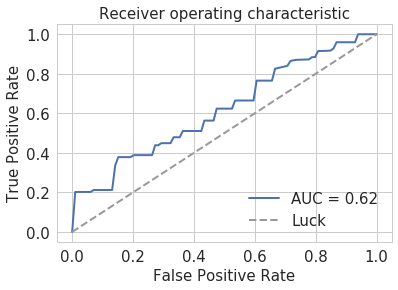

In [16]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
fontsize = 15

for i, (fpr, tpr) in enumerate(CV_fpr_tpr):
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)

mean_tpr /= len(CV_fpr_tpr)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

with sns.axes_style("whitegrid"):
    label_str = 'AUC = {:3.2f}'.format(mean_auc)
    plt.plot(mean_fpr, mean_tpr, label=label_str, lw=2)               

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize = fontsize)
plt.ylabel('True Positive Rate',fontsize = fontsize)
plt.title('Receiver operating characteristic',fontsize = fontsize)

# Plot the diagonal 
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck', lw=2)

plt.legend(loc="lower right",fontsize = fontsize)
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);

# Things you can play around to improve the performance

- Models: Different models + Hyper-parameters
- Preproc: Dimensionality reduction (e.g. PCA/ICA)
- Measures: Different connectivity metrics
- Priors: Different atlases
- Some (magical) combination of all of these.. 





# Unsupervised Learning 
 * Subtyping using clustering
 
The goal is to find subgroups of subjects with similar features (phenotypes / connectivity patterns) 

In [17]:
n_roi = 1000
conn_matrices_trunc = X[:,:n_roi]
func_connect_df = pd.DataFrame(conn_matrices_trunc)
print('input data shape: {}'.format(func_connect_df.shape))

input data shape: (172, 1000)


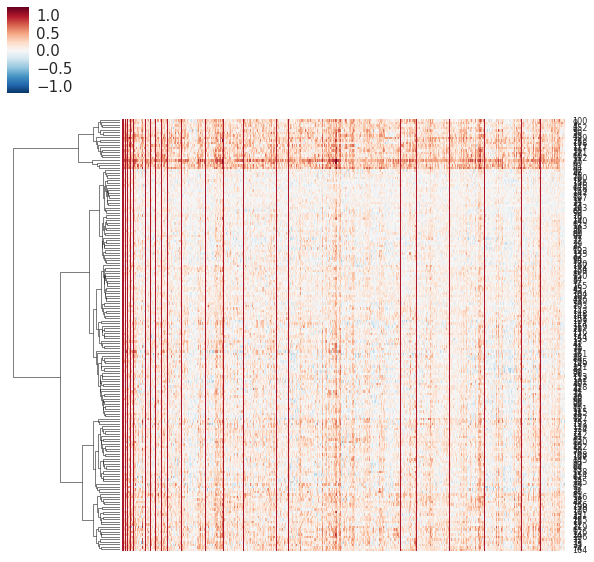

In [21]:
## Plot single correlation plot for visualization of clusters (No CV)
sns.set(style="white")
sns.set(font_scale=1.5)

similarity_metric = 'euclidean'
linkage_metric = 'ward'

g = sns.clustermap(func_connect_df, row_cluster=True, col_cluster=False, metric = similarity_metric, 
                   method= linkage_metric, figsize=(10, 10),xticklabels=False, yticklabels=True)

plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);

* **Get subject - Cluster memberships**

In [19]:
num_of_clusters = 2
Z = g.dendrogram_row.linkage
C = sch.fcluster(Z, num_of_clusters, 'maxclust')
print('Number of subs in C1: {}, C2: {}'.format(np.sum(C==1),np.sum(C==2)))

Number of subs in C1: 20, C2: 152


* **Visualize connectomes based on cluster membership**

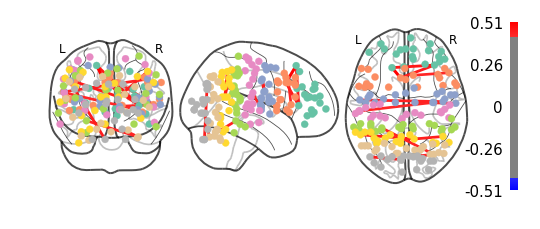

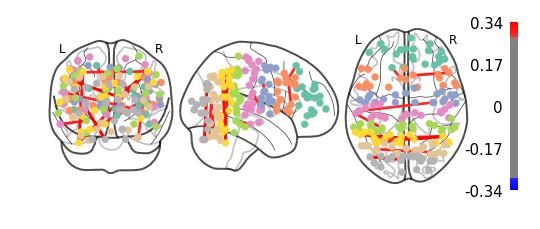

In [20]:
C1_connectome = np.mean(conn_matrices[C==1,1:,1:],axis=0)
C2_connectome = np.mean(conn_matrices[C==2,1:,1:],axis=0)
plotting.plot_connectome(C1_connectome, node_coords = coords, edge_threshold='99.9%',colorbar=True)
plotting.plot_connectome(C2_connectome, node_coords = coords, edge_threshold='99.9%',colorbar=True)